# Reproduce the Laplace package 
The Laplace package facilitates the application of Laplace approximations for entire neural networks, subnetworks of neural networks, or just their last layer. This project reproduces the Laplace package for learning purposes. </br>
This notebook shows how the reproduced Laplace can be used for parameter posterior approximation, hyper-parameter tuning, and prediction. Furthermore, the results are compared with Bayesian linear regression, and the Laplace package.
## References
[Laplace: Laplace approximations for Deep Learning.](https://github.com/AlexImmer/Laplace/tree/main)
```  
@inproceedings{laplace2021,
  title={Laplace Redux--Effortless {B}ayesian Deep Learning},
  author={Erik Daxberger and Agustinus Kristiadi and Alexander Immer 
          and Runa Eschenhagen and Matthias Bauer and Philipp Hennig},
  booktitle={{N}eur{IPS}},
  year={2021}
}
@inproceedings{dangel2020backpack,
    title     = {Back{PACK}: Packing more into Backprop},
    author    = {Felix Dangel and Frederik Kunstner and Philipp Hennig},
    booktitle = {International Conference on Learning Representations},
    year      = {2020},
    url       = {https://openreview.net/forum?id=BJlrF24twB}
}
```

In [2]:
import math

import torch 
import torch.nn as nn

import numpy as np 
import matplotlib.pyplot as plt

from LABDL.models import BayesianLinearRegression
from LABDL.data.generator import * 
from LABDL.laplace import Laplace as LA
from LABDL.laplace import marglik_training as LA_marglik_training
from LABDL.laplace.curvatures import BackPackGGN as BPG
from LABDL.trainer.training import *

from laplace import Laplace, marglik_training
from laplace.curvature.backpack import BackPackGGN

In [3]:
%reload_ext autoreload 
%autoreload 2

## Linear toy data
First, we set up the training data for the problem with observation noise ($\sigma=0.2$):

Text(0.5, 1.0, 'training samples, f(x) = 0.3x+(-0.7), sigma=0.2')

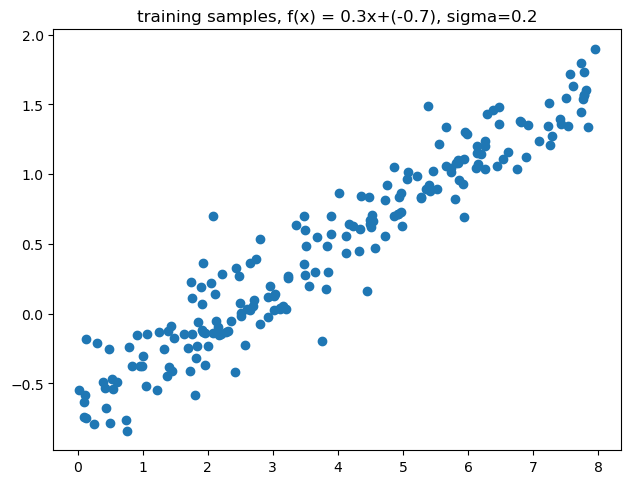

In [4]:
slope, bias = 0.3, -0.7
X_train, y_train, train_loader, X_test = get_linear_examples(slope=slope, bias=bias)
fig, axs = plt.subplots()
fig.tight_layout()
axs.plot(X_train, y_train, 'o')
axs.set_title(f"training samples, f(x) = {slope}x+({bias}), sigma=0.2")

## Models' set up: Bayesian linear regression, reproduced-Laplace, and Laplace.
As mentioned earlier, three models are tested and compared: the Bayesian linear regression, the Laplace reproduced in this project, and the Laplace package. 
### Bayesian linear regression
We can use the Bayesian linear regression to analytical compute the posterior, the predictive, and the marginal likelihood, i.e. the data evidence. 

In [27]:
blr = BayesianLinearRegression(X_train, y_train)
criterion = nn.MSELoss(reduction='mean')
preds, _ = blr.predict(X_train)
blr_loss = criterion(preds, y_train)
print(f"Averaged MSE Loss of Bayesian linear regression: {blr_loss/len(train_loader.dataset): .5f}")

Averaged MSE Loss of Bayesian linear regression:  0.00019


### Reproduced-Laplace and the Laplace
We use `pytorch` to train a simple linear layer with only two parameters, the weight and bias. The trained linear model will be our MAP estimate.  </br>
Then we set up and fit the Reproduced-Laplace and the Laplace model, whose Hessian is approximated by full GGN matrix.

In [72]:
def get_model(): 
    return nn.Linear(1, 1)

model = get_model()
print(model)

Linear(in_features=1, out_features=1, bias=True)


In [33]:
# fit model to obtain the MAP estimate parameter, the parameters are normally centered-distributed.
loss = train(model, train_loader)
for name, params in model.named_parameters():
    print(name)
    print(params)

=============EPOCH 1==============
loss_train: 0.218
=============EPOCH 101==============
loss_train: 0.001
=============EPOCH 201==============
loss_train: 0.001
=============EPOCH 301==============
loss_train: 0.001
=============EPOCH 401==============
loss_train: 0.001
Finished Training.
weight
Parameter containing:
tensor([[0.3008]], requires_grad=True)
bias
Parameter containing:
tensor([-0.6907], requires_grad=True)


In [35]:
print(f"Averaged MSE Loss of fitted linear layer: {loss: .5f}")

Averaged MSE Loss of fitted linear layer:  0.00356


In [36]:
la_post_hoc = LA(model, likelihood='regression', subset_of_weights='all', hessian_structure='full')
#la = FullLaplace(model)
la_post_hoc.fit(train_loader) 

In [37]:
lat_post_hoc = Laplace(model, 'regression', subset_of_weights='all', hessian_structure='full')
lat_post_hoc.fit(train_loader)

### Test
We examine the equality of the posterior, predictive posterior, and marginal likelihood of three models. </br>
Since we actually fit the based model with MLE estimate without the regularization of prior, the posterior mean of Laplace-approximated models fails the equality test when the absolute tolerance is set at `1e-3`.</br>
It further results in some deviation on the predictive posterior, and the marginal likelihood.

In [38]:
mean_blr = blr.mean.flatten()
pos_blr = blr.posterior_precision.detach().numpy()

mean_la_post_hoc = la_post_hoc.mean.detach().numpy()
pos_la_post_hoc = la_post_hoc.posterior_precision.detach().numpy()

mean_lat_post_hoc = lat_post_hoc.mean.detach().numpy()
pos_lat_post_hoc = lat_post_hoc.posterior_precision.detach().numpy()

np.testing.assert_allclose(mean_la_post_hoc, mean_lat_post_hoc, atol=1e-6)
np.testing.assert_allclose(pos_la_post_hoc, pos_lat_post_hoc, atol=1e-6)

np.testing.assert_allclose(pos_blr, pos_la_post_hoc, atol=1e-3)
np.testing.assert_allclose(mean_blr, mean_la_post_hoc, atol=1e-1)
print('posterior mean test with atol = 1e-1 pass')
np.testing.assert_allclose(mean_blr, mean_la_post_hoc, atol=1e-2)
print('åpsterior mean test with atol = 1e-2 pass')
np.testing.assert_allclose(mean_blr, mean_la_post_hoc, atol=1e-3)
print('åpsterior mean test with atol = 1e-3 pass')

posterior mean test with atol = 1e-1 pass


AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0.01

Mismatched elements: 2 / 2 (100%)
Max absolute difference: 0.05160272
Max relative difference: 0.07470616
 x: array([ 0.286996, -0.63914 ], dtype=float32)
 y: array([ 0.300787, -0.690742], dtype=float32)

In [40]:
pred_mean_blr, pred_var_blr = blr.predict(X_test)
pred_mean_blr, pred_var_blr = pred_mean_blr.flatten().detach().numpy(), pred_var_blr.flatten().detach().numpy()

pred_mean_la_post_hoc, f_var_la_post_hoc = la_post_hoc.predict(X_test)
pred_var_la_post_hoc = f_var_la_post_hoc + torch.ones(1)
pred_mean_la_post_hoc, pred_var_la_post_hoc = pred_mean_la_post_hoc.flatten().detach().numpy(), pred_var_la_post_hoc.flatten().detach().numpy()

f_mean_lat_post_hoc, f_var_lat_post_hoc = lat_post_hoc(X_test)
pred_var_lat_post_hoc = f_var_lat_post_hoc + torch.ones(1)
pred_mean_lat_post_hoc, pred_var_lat_post_hoc = f_mean_lat_post_hoc.flatten().detach().numpy(), pred_var_lat_post_hoc.flatten().detach().numpy()

np.testing.assert_allclose(pred_mean_la_post_hoc, pred_mean_lat_post_hoc, atol=1e-6)
np.testing.assert_allclose(pred_var_la_post_hoc, pred_var_lat_post_hoc, atol=1e-6)


np.testing.assert_allclose(pred_var_la_post_hoc, pred_var_blr, atol=1e-3) 
np.testing.assert_allclose(pred_mean_la_post_hoc, pred_mean_blr, atol=1)
print('predictive posterior mean test with atol = 1 pass')
np.testing.assert_allclose(pred_mean_la_post_hoc, pred_mean_blr, atol=1e-1)
print('predictive posterior mean test with atol = 1e-1 pass')
np.testing.assert_allclose(pred_mean_la_post_hoc, pred_mean_blr, atol=1e-2)
print('predictive posterior mean test with atol = 1e-2 pass')

predictive posterior mean test with atol = 1 pass


AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0.1

Mismatched elements: 98 / 500 (19.6%)
Max absolute difference: 0.12768221
Max relative difference: 5.839384
 x: array([-2.194679e+00, -2.183829e+00, -2.172979e+00, -2.162129e+00,
       -2.151279e+00, -2.140429e+00, -2.129579e+00, -2.118729e+00,
       -2.107879e+00, -2.097029e+00, -2.086179e+00, -2.075328e+00,...
 y: array([-2.074121, -2.063768, -2.053415, -2.043063, -2.03271 , -2.022358,
       -2.012005, -2.001653, -1.9913  , -1.980947, -1.970595, -1.960242,
       -1.94989 , -1.939537, -1.929185, -1.918832, -1.90848 , -1.898127,...

In [41]:
def plot(X_train, y_train, X_test, f_mu, pred_std):
    fig, axs = plt.subplots()
    fig.tight_layout()
    axs.plot(X_train, y_train, 'o')
    axs.plot(X_test, f_mu, 'o')
    axs.fill_between(X_test.flatten(), f_mu - 2*pred_std, f_mu + 2*pred_std, alpha=0.2)

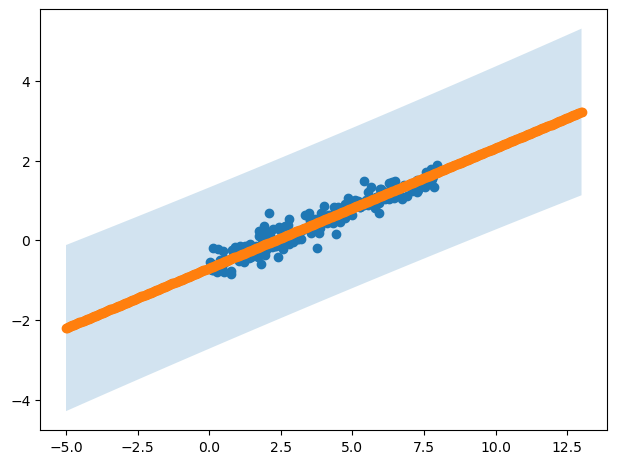

In [42]:
plot(X_train, y_train, X_test, pred_mean_la_post_hoc, np.sqrt(pred_var_la_post_hoc))

### post-hoc tuning

In [43]:
n_epochs = 1000

In [44]:
# Bayesian linear regression
log_sigma = torch.ones(1, requires_grad=True) # log std deviation of the regression Gaussian noise
log_prior_var = torch.ones(1, requires_grad=True) # log variance of parameter prior 
lr = 1e-1
optimizer = torch.optim.Adam([log_prior_var, log_sigma], lr=lr)
for epoch in range(n_epochs): 
    optimizer.zero_grad()
    neg_log_marg_lik = -blr.log_marginal_likelihood(log_prior_var.exp(), log_sigma.exp())
    neg_log_marg_lik.backward()
    optimizer.step()

In [45]:
# LA-based
log_sigma = torch.ones(1, requires_grad=True) # log std deviation of the regression Gaussian noise
log_prior_var = torch.ones(1, requires_grad=True) # log variance of parameter prior 
lr = 1e-1
optimizer = torch.optim.Adam([log_prior_var, log_sigma], lr=lr)
for epoch in range(n_epochs): 
    optimizer.zero_grad()
    neg_log_marg_lik = - la_post_hoc.log_marginal_likelihood(log_prior_var.exp(), log_sigma.exp())
    neg_log_marg_lik.backward()
    optimizer.step()

In [46]:
# laplace-torch
log_prior_, log_sigma_ = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior_, log_sigma_], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - lat_post_hoc.log_marginal_likelihood(log_prior_.exp(), log_sigma_.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [48]:
sigma_noise_blr = blr.sigma_noise.detach().numpy()
prior_precision_blr = blr.prior_precision.detach().numpy()

sigma_noise_la_post_hoc = la_post_hoc.sigma_noise.detach().numpy()
prior_precision_la_post_hoc = la_post_hoc.prior_precision.detach().numpy()

sigma_noise_lat_post_hoc= lat_post_hoc.sigma_noise.detach().numpy()
prior_precision_lat_post_hoc = lat_post_hoc.prior_precision.detach().numpy()

In [51]:
np.testing.assert_allclose(sigma_noise_lat_post_hoc, sigma_noise_la_post_hoc, atol=1e-3)
np.testing.assert_allclose(prior_precision_lat_post_hoc, prior_precision_la_post_hoc, atol=1e-3)

np.testing.assert_allclose(sigma_noise_blr, sigma_noise_la_post_hoc, atol=1e-2)
np.testing.assert_allclose(prior_precision_blr, prior_precision_la_post_hoc, atol=1e-1)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0.1

Mismatched elements: 1 / 1 (100%)
Max absolute difference: 0.41854167
Max relative difference: 0.11895176
 x: array([3.937125], dtype=float32)
 y: array([3.518583], dtype=float32)

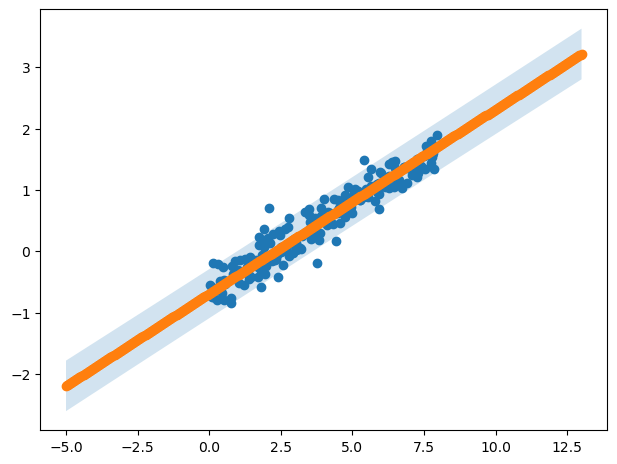

In [54]:
pred_mean_la, f_var_la = la_post_hoc.predict(X_test)
pred_var_la = f_var_la + torch.ones(1)*la_post_hoc.sigma_noise**2
pred_mean_la, pred_var_la = pred_mean_la.flatten().detach().numpy(), pred_var_la.flatten().detach().numpy()

plot(X_train, y_train, X_test, pred_mean_la, np.sqrt(pred_var_la))

### online tuning

In [73]:
n_epochs = 500

In [74]:
model = get_model()
latorch, model_torch, margliks_torch, losses_torch = marglik_training(
    model=model, train_loader=train_loader, likelihood='regression',
    hessian_structure='full', backend=BackPackGGN, n_epochs=n_epochs, 
    optimizer_kwargs={'lr': 1e-2}, prior_structure='scalar'
)

In [75]:
print(latorch.mean)
print(latorch.sigma_noise)
print(latorch.prior_precision)
print(latorch.posterior_precision)

tensor([ 0.2916, -0.6474])
tensor(0.1969)
tensor([3.9655])
tensor([[101255.5234,  19750.5879],
        [ 19750.5879,   5161.6460]])


In [81]:
model = get_model()
la, model_la, margliks, losses = LA_marglik_training(
    model=model, train_loader=train_loader, likelihood='regression',
    hessian_structure='full', backend=BPG, n_epochs=n_epochs, 
    optimizer_kwargs={'lr': 1e-2}, prior_structure='scalar'
)

MARGLIK: finished training. Recover best model and fit Laplace.


In [82]:
print(la.sigma_noise)
print(la.prior_precision)
print(la.posterior_precision)
print(la.mean)

tensor([0.1969])
tensor([3.9666])
tensor([[101257.2109,  19750.9180],
        [ 19750.9180,   5161.7334]])
tensor([ 0.2914, -0.6463], grad_fn=<CatBackward0>)


In [80]:
print(blr.sigma_noise)
print(blr.prior_precision)
print(blr.posterior_precision)
print(blr.mean)

tensor([0.1965], grad_fn=<ExpBackward0>)
tensor([3.9371], grad_fn=<MulBackward0>)
tensor([[101725.7188,  19842.3125],
        [ 19842.3125,   5185.5713]], grad_fn=<AddBackward0>)
tensor([[ 0.2893],
        [-0.6508]], grad_fn=<MmBackward0>)


In [79]:
mean_la = la.mean.detach().numpy()
pos_la = la.posterior_precision.detach().numpy()

mean_latorch = latorch.mean.flatten()
pos_latorch = latorch.posterior_precision.detach().numpy()

np.testing.assert_allclose(mean_latorch, mean_la, atol=1e-2)
np.testing.assert_allclose(pos_latorch, pos_la, atol=1e-2)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0.01

Mismatched elements: 4 / 4 (100%)
Max absolute difference: 852.3672
Max relative difference: 0.00834886
 x: array([[101255.52 ,  19750.588],
       [ 19750.588,   5161.646]], dtype=float32)
 y: array([[102107.89 ,  19916.871],
       [ 19916.871,   5204.99 ]], dtype=float32)

In [61]:
mean_blr = blr.mean.detach().flatten().numpy()
pos_blr = blr.posterior_precision.detach().numpy()

mean_la = la.mean.detach().numpy()
pos_la = la.posterior_precision.detach().numpy()

mean_latorch = latorch.mean.flatten()
pos_latorch = latorch.posterior_precision.detach().numpy()

np.testing.assert_allclose(mean_latorch, mean_la, atol=1e-3)
np.testing.assert_allclose(pos_latorch, pos_la, atol=1e-3)


np.testing.assert_allclose(pos_blr, pos_la, atol=1)
np.testing.assert_allclose(mean_blr, mean_la, atol=1e-3)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0.001

Mismatched elements: 2 / 2 (100%)
Max absolute difference: 0.03906167
Max relative difference: 0.05699519
 x: array([ 0.291482, -0.646289], dtype=float32)
 y: array([ 0.297386, -0.68535 ], dtype=float32)

In [42]:
f_mu, f_var = la.predict(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

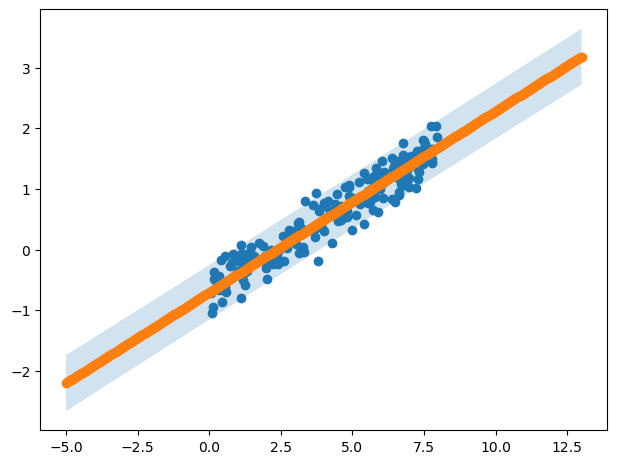

In [45]:
plot(X_train, y_train, X_test, f_mu, pred_std)